In [202]:
import pandas as pd
import nltk
from pathlib import Path
import re
import string
import requests
from nltk import sent_tokenize
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from afinn import Afinn
import numpy as np
import networkx as nx
from tabulate import tabulate



## Top words from algorithm

In [203]:
top_words=s1.classifier.most_informative_features()[0:50]
len(top_words)
[x[0] for x in top_words]

['turgid',
 'unfunny',
 'superlative',
 'radiant',
 'quotable',
 'talkie',
 'unpretentious',
 'flawless',
 'atrocious',
 'influential',
 'lighten',
 'robust',
 'exuberant',
 'lousy',
 'pointless',
 'horrid',
 'laughable',
 'sadness',
 'worst',
 'longs',
 'speakeasy',
 'adjust',
 'abysmal',
 'unlikeable',
 'perceptive',
 'uncompromising',
 'fairytale',
 'awful',
 'astonishing',
 'puerile',
 'poorly',
 'sceptical',
 'lame',
 'infectious',
 'insipid',
 'bearable',
 'nonexistent',
 'uninspired',
 'audible',
 'mower',
 'undying',
 'humane',
 'polar',
 'unoriginal',
 'tedious',
 'breathtaking',
 'unintentional',
 'amateurish',
 'relaxed',
 'insult']

In [204]:
from re import search
import s1_analysis
import collections
s1 = s1_analysis.s1_analysis()
s1.train_load("s1_model_2.sav")
pubs = []
names_list = ["Biden", "Bernie", "Warren", "Kamala"]
top_words=s1.classifier.most_informative_features()[0:50]
top_words=[x[0] for x in top_words]
# read in data and sentence tokenize it
df = pd.read_csv('vikas.csv')
df['tokenized_sents'] = df.apply(
    lambda row: nltk.sent_tokenize(row['full_art']), axis=1)


# split df into dictionary with keys representing publisher and values representing df for those publishers
sources = {}
for source, df_source in df.groupby('source'):
    sources[source] = df_source

# grabs all sentences which mention candidate


def get_candidate_mentions(candidate_name, publisher, tokenize_level):
    mentions = []
    substring = candidate_name
    for article in sources[publisher][tokenize_level]:
        for sentence in article:
            if search(substring, sentence):
                mentions.append(sentence)
            else:
                continue
    return(mentions)


def get_sentiment_scores(names_list, publisher, tokenize_level, no_duplicates=None):
   # will store cand name and sentiment scores
    cand_sent = {}
    top_words_dict= {}
    # build cand mention lists
    joe_biden_mentions = get_candidate_mentions(
        "Biden|Joe Biden", publisher, tokenize_level)
    bernie_mentions = get_candidate_mentions(
        "Bernie|Sanders", publisher, tokenize_level)
    Warren_mentions = get_candidate_mentions(
        "Warren|Elizabeth Warren", publisher, tokenize_level)
    Kamala_mentions = get_candidate_mentions(
        "Kamala|Harris", publisher, tokenize_level)

    # build lists for sentiment scoring loop
    cand_list = [joe_biden_mentions, bernie_mentions,
                 Warren_mentions, Kamala_mentions]

    # If we want to eliminate sentences with multiple candididate mentions, we call fucntion
    # with no_duplicates=1 and this block executes

    if no_duplicates == 1:

        # shared_sent will grab any shared sentences
        shared_sent = []
        for x in joe_biden_mentions:
            if search("Bernie|Sanders|Warren|Elizabeth Warren|Kamala|Harris", x):
                shared_sent.append(x)
        for x in bernie_mentions:
            if search("Joe|Joe Biden|Warren|Elizabeth Warren|Kamala|Harris", x):
                shared_sent.append(x)
        for x in Warren_mentions:
            if search("Joe|Joe Biden|Bernie|Sanders|Kamala|Harris", x):
                shared_sent.append(x)
        for x in Kamala_mentions:
            if search("Joe|Joe Biden|Bernie|Sanders|Warren|Elizabeth Warren", x):
                shared_sent.append(x)

        # use shared sent list to remove shared sent from each candidates sentence list
        for cand in cand_list:
            for sent in cand:
                if sent in shared_sent:
                    cand.remove(sent)
    # run sentiment score on each candidate and get count/store in returned dictionary
    for i, candidate in enumerate(cand_list):
        features = []
        results = []
        top_word_counts_freq=[]
        for sentence in candidate:
            for topword in top_words:
                if topword in sentence:
                    top_word_counts_freq.append(topword)
        features = [s1.find_features(x) for x in candidate]
        results = [s1.classifier.classify(x) for x in features]
        counter = collections.Counter(results)
        cand_sent[names_list[i]] = counter
        counter = collections.Counter(top_word_counts_freq)
        top_words_dict[names_list[i]] = counter
    ## data checks
    print(top_words_dict)
    print(cand_sent)
    return(cand_sent,top_words_dict)

       
## Proba scoring 
           
    ##proba_results = [s1.classifier.prob_classify(x) for x in features]
        # avg_sentiment=np.mean([x.prob("pos") for x in proba_results])        
        # print(avg_sentiment)
        #  proba_scores["pos"]= [x.prob("pos") for x in proba_results[1]]
        #  print(proba_scores)
        # cand_sent[names_list[i]] = avg_sentiment
        


## Visualize results 

In [205]:
df.shape

(5274, 11)

In [206]:
# will return a dictionary that as a key gives candidate name and as a value
# gives another dictionary with candidates name as key and sentiment scores as values

#all_publishers = {}
#pubnames = [x for x in sources.keys()]
#for i, publisher in enumerate(pubnames):
#   # pubs.append(get_sentiment_scores(names_list,publisher))
#    scores = get_sentiment_scores(names_list, publisher, 'tokenized_sents')
#    all_publishers[publisher] = scores
    
    
all_publishers_scores = {}
all_words_counts={}
pubnames = [x for x in sources.keys()]
for i, publisher in enumerate(pubnames):
   # pubs.append(get_sentiment_scores(names_list,publisher))
    scores = get_sentiment_scores(names_list, publisher, 'tokenized_sents',1)
    all_publishers_scores[publisher] = scores[0]
    all_words_counts[publisher] = scores[1]

{'Biden': Counter(), 'Bernie': Counter(), 'Warren': Counter(), 'Kamala': Counter()}
{'Biden': Counter({'neg': 4, 'pos': 3}), 'Bernie': Counter({'neg': 2}), 'Warren': Counter({'neg': 4, 'pos': 4}), 'Kamala': Counter({'neg': 1})}
{'Biden': Counter({'longs': 7, 'lame': 6, 'awful': 5, 'insult': 4, 'worst': 2, 'astonishing': 1}), 'Bernie': Counter({'longs': 12, 'lame': 3, 'robust': 2}), 'Warren': Counter({'longs': 4, 'worst': 1, 'lame': 1}), 'Kamala': Counter({'longs': 2, 'lame': 1})}
{'Biden': Counter({'neg': 1428, 'pos': 1359}), 'Bernie': Counter({'neg': 440, 'pos': 388}), 'Warren': Counter({'neg': 494, 'pos': 383}), 'Kamala': Counter({'pos': 179, 'neg': 170})}
{'Biden': Counter({'longs': 5, 'lame': 4, 'awful': 2, 'influential': 1, 'insult': 1}), 'Bernie': Counter({'longs': 1, 'humane': 1, 'robust': 1, 'adjust': 1, 'polar': 1}), 'Warren': Counter({'longs': 2, 'robust': 2, 'influential': 1, 'adjust': 1, 'worst': 1}), 'Kamala': Counter()}
{'Biden': Counter({'neg': 896, 'pos': 799}), 'Bernie

{'Biden': ['longs',
  'robust',
  'insult',
  'awful',
  'worst',
  'awful',
  'awful',
  'lame',
  'awful',
  'awful',
  'longs',
  'lame',
  'awful',
  'influential',
  'awful',
  'awful',
  'awful',
  'awful',
  'awful',
  'lame',
  'robust',
  'adjust',
  'awful',
  'awful',
  'awful',
  'awful',
  'awful',
  'awful',
  'awful',
  'awful',
  'awful',
  'awful',
  'lighten',
  'awful',
  'awful',
  'awful',
  'awful',
  'nonexistent',
  'awful',
  'awful',
  'worst',
  'poorly',
  'influential',
  'robust',
  'adjust',
  'amateurish',
  'adjust',
  'lame',
  'awful',
  'nonexistent',
  'awful',
  'lame',
  'awful',
  'awful',
  'awful',
  'awful',
  'longs',
  'influential',
  'fairytale',
  'robust',
  'lame',
  'relaxed',
  'sadness',
  'nonexistent',
  'laughable',
  'poorly',
  'lame',
  'sadness',
  'lame',
  'polar',
  'poorly',
  'worst',
  'insult',
  'laughable',
  'insult',
  'influential',
  'influential',
  'pointless',
  'poorly',
  'influential',
  'worst',
  'awful',


## Build Nested df

In [207]:
new_df= pd.DataFrame.from_dict({(i,j): all_publishers_scores[i][j] 
                           for i in all_publishers_scores.keys() 
                           for j in all_publishers_scores[i].keys()},
                       orient='index')
new_df['Percent_positive'] =   new_df['pos']/(new_df['pos']+new_df['neg'])
new_df

neg     pos  Percent_positive
Bloomberg               Bernie     2     NaN               NaN
                        Biden      4     3.0          0.428571
                        Kamala     1     NaN               NaN
                        Warren     4     4.0          0.500000
Breitbart News          Bernie   440   388.0          0.468599
                        Biden   1428  1359.0          0.487621
                        Kamala   170   179.0          0.512894
                        Warren   494   383.0          0.436716
CNN                     Bernie   243   207.0          0.460000
                        Biden    896   799.0          0.471386
                        Kamala    98    80.0          0.449438
                        Warren   344   284.0          0.452229
Fox News                Bernie   458   349.0          0.432466
                        Biden   1958  1943.0          0.498077
                        Kamala   219   159.0          0.420635
                        Warren   578   430.0          0.426587
Google News             Bernie    20    15.0          0.428571
                        Biden     16    12.0          0.428571
                        Kamala     1     5.0          0.833333
                        Warren    27    15.0          0.357143
MSNBC                   Bernie    28    24.0          0.461538
                        Biden    101   106.0          0.512077
                        Kamala     5    12.0          0.705882
                        Warren    26    19.0          0.422222
New York Magazine       Bernie   150   128.0          0.460432
                        Biden    386   345.0          0.471956
                        Kamala    56    36.0          0.391304
                        Warren   197   163.0          0.452778
The New York Times      Bernie   138   110.0          0.443548
                        Biden    236   298.0          0.558052
                        Kamala    29    24.0          0.452830
                        Warren   159   145.0          0.476974
The Wall Street Journal Bernie    13    14.0          0.518519
                        Biden     64    73.0          0.532847
                        Kamala     7     2.0          0.222222
                        Warren    36    39.0          0.520000
The Washington Post     Bernie  1048   784.0          0.427948
                        Biden   3062  2778.0          0.475685
                        Kamala   499   316.0          0.387730
                        Warren  1315   946.0          0.418399

## Create DF for n words 

In [219]:
all_words_counts

{'Bloomberg': {'Biden': Counter(),
  'Bernie': Counter(),
  'Warren': Counter(),
  'Kamala': Counter()},
 'Breitbart News': {'Biden': Counter({'lame': 6,
           'longs': 7,
           'awful': 5,
           'insult': 4,
           'worst': 2,
           'astonishing': 1}),
  'Bernie': Counter({'longs': 12, 'robust': 2, 'lame': 3}),
  'Warren': Counter({'worst': 1, 'longs': 4, 'lame': 1}),
  'Kamala': Counter({'lame': 1, 'longs': 2})},
 'CNN': {'Biden': Counter({'longs': 5,
           'influential': 1,
           'lame': 4,
           'insult': 1,
           'awful': 2}),
  'Bernie': Counter({'longs': 1,
           'humane': 1,
           'robust': 1,
           'adjust': 1,
           'polar': 1}),
  'Warren': Counter({'longs': 2,
           'influential': 1,
           'robust': 2,
           'adjust': 1,
           'worst': 1}),
  'Kamala': Counter()},
 'Fox News': {'Biden': Counter({'lame': 8,
           'longs': 9,
           'astonishing': 2,
           'unintentional': 1,
   

In [221]:
new_df2= pd.DataFrame.from_dict({(i,j): all_words_counts[i][j] 
                           for i in all_words_counts.keys() 
                           for j in all_words_counts[i].keys()},
                       orient='index')

#new_df['Percent_positive'] =   new_df['pos']/(new_df['pos']+new_df['neg'])
new_df2
##new_df2.to_csv("word_freq_counts.csv")

lame  longs  awful  insult  worst  astonishing  \
Breitbart News      Bernie   3.0   12.0    NaN     NaN    NaN          NaN   
                    Biden    6.0    7.0    5.0     4.0    2.0          1.0   
                    Kamala   1.0    2.0    NaN     NaN    NaN          NaN   
                    Warren   1.0    4.0    NaN     NaN    1.0          NaN   
CNN                 Bernie   NaN    1.0    NaN     NaN    NaN          NaN   
                    Biden    4.0    5.0    2.0     1.0    NaN          NaN   
                    Warren   NaN    2.0    NaN     NaN    1.0          NaN   
Fox News            Bernie   4.0    5.0    1.0     NaN    NaN          1.0   
                    Biden    8.0    9.0    5.0     2.0    3.0          2.0   
                    Kamala   4.0    NaN    NaN     1.0    NaN          NaN   
                    Warren   NaN    6.0    1.0     NaN    1.0          NaN   
MSNBC               Bernie   NaN    1.0    NaN     NaN    NaN          NaN   
                    Biden    1.0    NaN    NaN     NaN    NaN          NaN   
                    Kamala   NaN    NaN    1.0     NaN    NaN          NaN   
New York Magazine   Bernie   NaN    NaN    NaN     NaN    NaN          1.0   
                    Biden    1.0    NaN    1.0     1.0    NaN          1.0   
                    Kamala   1.0    NaN    1.0     NaN    NaN          NaN   
                    Warren   1.0    1.0    NaN     1.0    NaN          NaN   
The New York Times  Bernie   NaN    NaN    NaN     NaN    NaN          NaN   
                    Biden    NaN    5.0    1.0     1.0    3.0          1.0   
                    Kamala   NaN    NaN    NaN     NaN    NaN          NaN   
                    Warren   NaN    1.0    NaN     NaN    1.0          NaN   
The Washington Post Bernie   1.0    NaN    NaN     1.0    1.0          NaN   
                    Biden    8.0    3.0   35.0     3.0    3.0          NaN   
                    Kamala   3.0    3.0    NaN     2.0    NaN          NaN   
                    Warren   4.0    1.0    1.0     NaN    5.0          NaN   

                            robust  influential  humane  adjust    ...      \
Breitbart News      Bernie     2.0          NaN     NaN     NaN    ...       
                    Biden      NaN          NaN     NaN     NaN    ...       
                    Kamala     NaN          NaN     NaN     NaN    ...       
                    Warren     NaN          NaN     NaN     NaN    ...       
CNN                 Bernie     1.0          NaN     1.0     1.0    ...       
                    Biden      NaN          1.0     NaN     NaN    ...       
                    Warren     2.0          1.0     NaN     1.0    ...       
Fox News            Bernie     1.0          NaN     NaN     NaN    ...       
                    Biden      NaN          1.0     NaN     NaN    ...       
                    Kamala     1.0          NaN     1.0     NaN    ...       
                    Warren     1.0          1.0     NaN     NaN    ...       
MSNBC               Bernie     NaN          NaN     NaN     NaN    ...       
                    Biden      NaN          NaN     NaN     NaN    ...       
                    Kamala     NaN          NaN     NaN     NaN    ...       
New York Magazine   Bernie     NaN          NaN     NaN     NaN    ...       
                    Biden      1.0          NaN     NaN     NaN    ...       
                    Kamala     NaN          NaN     NaN     NaN    ...       
                    Warren     NaN          2.0     NaN     NaN    ...       
The New York Times  Bernie     NaN          1.0     NaN     NaN    ...       
                    Biden      NaN          NaN     NaN     1.0    ...       
                    Kamala     NaN          1.0     NaN     NaN    ...       
                    Warren     NaN          NaN     NaN     NaN    ...       
The Washington Post Bernie     3.0          2.0     NaN     2.0    ...       
                    Biden      4.0          5.0  

## Failed plot

40
<class 'float'>


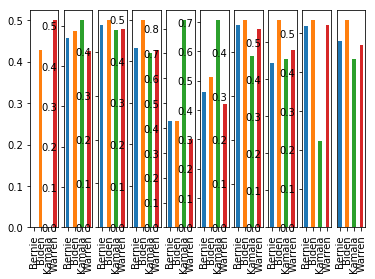

In [151]:
import matplotlib.pyplot as plt
data=[x for x in new_df["Percent_positive"]]
idx=["Bernie","Biden","Kamala","Warren"]*10
# how many bar charts we expect
ser= pd.Series(data,index=idx)
numofcharts = len(ser) / 4
print(len(ser))
print(type(numofcharts)) 
# prepare axes for subplots (1 row, numofcharts columns one per bar chart)
fig, axs = plt.subplots(1, int(numofcharts))
d=0
for graphi in range(int(numofcharts)):
    starti = 4*graphi
    d+=1
# create subseries one for each subchart
    subser = ser[starti:starti+4]
# print subseries, to see, what we are going to plot
#    print (subser)
# plot subseries as bar subchart
    subser.plot(ax=axs[graphi], kind="bar")

    
plt.yticks([])
plt.show()

## Flatten DF and save to file

In [227]:
newer_df=new_df.reset_index()
pd.DataFrame.to_csv(newer_df, "final_proj_df.csv")
newer_df

,level_0,level_1,neg,pos,Percent_positive
0,Bloomberg,Bernie,2,NaN,NaN
1,Bloomberg,Biden,4,3.0,0.428571
2,Bloomberg,Kamala,1,NaN,NaN
3,Bloomberg,Warren,4,4.0,0.500000
4,Breitbart News,Bernie,440,388.0,0.468599
5,Breitbart News,Biden,1428,1359.0,0.487621
6,Breitbart News,Kamala,170,179.0,0.512894
7,Breitbart News,Warren,494,383.0,0.436716
8,CNN,Bernie,243,207.0,0.460000
9,CNN,Biden,896,799.0,0.471386


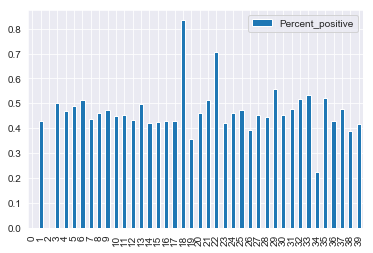

In [224]:
new_sources={}
for source, df_source in new_df.reset_index().groupby("level_0"):
    new_sources[source] = df_source   
new_sources

pd.DataFrame(newer_df["Percent_positive"]).plot(kind='bar')
plt.show()

In [225]:

# new_df2= pd.DataFrame.from_dict({(i,j): all_publishers2[i][j] 
#                            for i in all_publishers2.keys() 
#                            for j in all_publishers2[i].keys()},
#                        orient='index')

# new_df2['Percent_positive'] =   new_df2['pos']/(new_df2['pos']+new_df2['neg'])
# new_df2

neg  pos  Percent_positive
Bloomberg Bernie    2  NaN               NaN
          Biden     4  3.0          0.428571
          Kamala    1  NaN               NaN
          Warren    4  4.0          0.500000

## Builds a dictionary which stores all the names used in all articles from CNN via Spacy-NER

In [195]:
# this will build a dictionary which stores all the names used in all articles from CNN
#sources["CNN"]['tokenized_sents'] = sources["CNN"].apply(
#    lambda row: nltk.sent_tokenize(row['full_art']), axis=1)
#article_dict = {}
#for i, x in enumerate(sources["CNN"]['tokenized_sents']):
#    article_dict[i] = nlist(x)
#    print(i)

In [196]:
#features = []
#        results = []
 #       features = [s1.find_features(x) for x in candidate]
#        results = [s1.classifier.classify(x) for x in features]
#        counter = collections.Counter(results)
#all_publishers = {}
#pubnames = [x for x in sources.keys()]
#for i, publisher in enumerate(pubnames):
#   # pubs.append(get_sentiment_scores(names_list,publisher))
#    scores = get_sentiment_scores(names_list, publisher, 'tokenized_sents')#
#    print(scores)
#    all_publishers[publisher] = scores

IndentationError: unexpected indent (<ipython-input-196-a19d2f47f0d0>, line 2)

In [200]:
newer_df[newer_df['level_1']== "Bernie"]
candidate_names=newer_df['level_1'].unique()

## result printout


In [194]:
for cand in candidate_names:
    cand_df=newer_df[newer_df['level_1']== cand] 
    cand_df=cand_df[cand_df['level_0']!= "Bloomberg"] 
    cand_df.loc['MEAN'] =  cand_df.mean()
    cand_df.loc['MEAN']=['NA','NA','NA','NA',cand_df.loc["MEAN"].pos/(cand_df.loc["MEAN"].pos+cand_df.loc["MEAN"].neg)]
    cand_df.style.applymap('font-weight: bold',
                  subset=pd.IndexSlice[cand_df.index[cand_df.index=='MEAN'], :])
    print(tabulate(cand_df, headers='keys', tablefmt='psql'))



+------+-------------------------+-----------+--------+-------+--------------------+
|      | level_0                 | level_1   | neg    | pos   |   Percent_positive |
|------+-------------------------+-----------+--------+-------+--------------------|
| 4    | Breitbart News          | Bernie    | 440.0  | 388.0 |           0.468599 |
| 8    | CNN                     | Bernie    | 243.0  | 207.0 |           0.46     |
| 12   | Fox News                | Bernie    | 458.0  | 349.0 |           0.432466 |
| 16   | Google News             | Bernie    | 20.0   | 15.0  |           0.428571 |
| 20   | MSNBC                   | Bernie    | 28.0   | 24.0  |           0.461538 |
| 24   | New York Magazine       | Bernie    | 150.0  | 128.0 |           0.460432 |
| 28   | The New York Times      | Bernie    | 138.0  | 110.0 |           0.443548 |
| 32   | The Wall Street Journal | Bernie    | 13.0   | 14.0  |           0.518519 |
| 36   | The Washington Post     | Bernie    | 1048.0 | 784.0 |  

In [181]:
candidate_names=newer_df['level_0'].unique()
def df_style(val):
    return 'font-weight: bold'
        
for cand in candidate_names:
    cand_df=newer_df[newer_df['level_0']== cand] 
    cand_df.loc['MEAN'] = cand_df.mean()
    cand_df.style.applymap('font-weight: bold',
                  subset=pd.IndexSlice[cand_df.index[cand_df.index=='MEAN'], :])
    print(tabulate(cand_df, headers='keys', tablefmt='psql'))
    

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


+------+-----------+-----------+-------+-------+--------------------+
|      | level_0   | level_1   |   neg |   pos |   Percent_positive |
|------+-----------+-----------+-------+-------+--------------------|
| 0    | Bloomberg | Bernie    |  2    | nan   |         nan        |
| 1    | Bloomberg | Biden     |  4    |   3   |           0.428571 |
| 2    | Bloomberg | Kamala    |  1    | nan   |         nan        |
| 3    | Bloomberg | Warren    |  4    |   4   |           0.5      |
| MEAN | nan       | nan       |  2.75 |   3.5 |           0.464286 |
+------+-----------+-----------+-------+-------+--------------------+
+------+----------------+-----------+-------+---------+--------------------+
|      | level_0        | level_1   |   neg |     pos |   Percent_positive |
|------+----------------+-----------+-------+---------+--------------------|
| 4    | Breitbart News | Bernie    |   440 |  388    |           0.468599 |
| 5    | Breitbart News | Biden     |  1428 | 1359    |       

In [226]:
for source, df_source in df.groupby('source'):
    sources[source] = df_source

## Extra code for other class

In [185]:
cand_sent = {}
# read in data and sentence tokenize it
df = pd.read_csv('vikas.csv')
df['tokenized_sents'] = df.apply(
    lambda row: nltk.sent_tokenize(row['full_art']), axis=1)


# split df into dictionary with keys representing publisher and values representing df for those publishers
sources = {}
for source, df_source in df.groupby('source'):
    sources[source] = df_source
# build cand mention lists
joe_biden_mentions = get_candidate_mentions(
    "Biden|Joe Biden", publisher, 'tokenized_sents')
bernie_mentions = get_candidate_mentions(
    "Bernie|Sanders", publisher, 'tokenized_sents')
Warren_mentions = get_candidate_mentions(
    "Warren|Elizabeth Warren", publisher, 'tokenized_sents')
Kamala_mentions = get_candidate_mentions(
    "Kamala|Harris", publisher, 'tokenized_sents')

# build lists for sentiment scoring loop
cand_list = [joe_biden_mentions, bernie_mentions,
             Warren_mentions, Kamala_mentions]

# If we want to eliminate sentences with multiple candididate mentions, we call fucntion
# with no_duplicates=1 and this block executes



# shared_sent will grab any shared sentences
shared_sent = []
for x in joe_biden_mentions:
    if search("Bernie|Sanders|Warren|Elizabeth Warren|Kamala|Harris", x):
        shared_sent.append(x)
for x in bernie_mentions:
    if search("Joe|Joe Biden|Warren|Elizabeth Warren|Kamala|Harris", x):
        shared_sent.append(x)
for x in Warren_mentions:
    if search("Joe|Joe Biden|Bernie|Sanders|Kamala|Harris", x):
        shared_sent.append(x)
for x in Kamala_mentions:
    if search("Joe|Joe Biden|Bernie|Sanders|Warren|Elizabeth Warren", x):
        shared_sent.append(x)

# use shared sent list to remove shared sent from each candidates sentence list
for cand in cand_list:
    for sent in cand:
        if sent in shared_sent:
            cand.remove(sent)

In [186]:
cand_mentions=joe_biden_mentions,bernie_mentions,Kamala_mentions,Warren_mentions
for i,cand in enumerate(cand_mentions):
    cand_text=''.join(cand)
    text_file = open("{}.txt".format(i), "w",encoding="utf-8")
    text_file.write(cand_text)
    text_file.close()
    

## Code for wordclouds


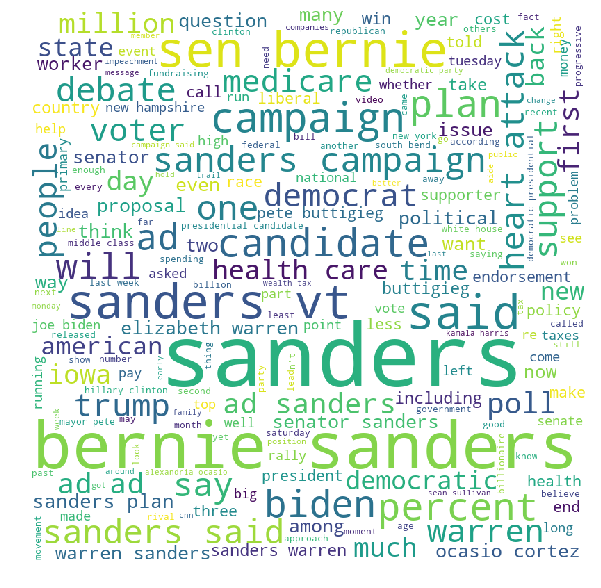

In [189]:

#stop_words = ["sanders", "bernie"] + list(STOPWORDS)
stop_words=  list(STOPWORDS)

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
#df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1") 


comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in tokeniz:
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split(" ") 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
 ##collocations=False| 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
#df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1") 


comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in sources["Breitbart News"]["full_art"][1:255]:
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Create text files from candidate files

In [ ]:


# text_file = open("bernie.txt", "w",encoding="utf-8")
# text_file.write(comment_words)
# text_file.close()

In [188]:
comment_words = ' '
stopwords = set(STOPWORDS) 
cand=
# iterate through the csv file 
for val in tokeniz:
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split(" ") 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
text_file = open("{}.txt".format(cand), "w",encoding="utf-8")
text_file.write(comment_words)
text_file.close()


SyntaxError: invalid syntax (<ipython-input-188-e566c67c2485>, line 3)